In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from client import Socket
from time import sleep

In [2]:
# connect

s = Socket()

trying to connect to:  raspberrypi.local 5005
connected, use send_recv(msg) to send data


In [3]:
# webcam input

cap = cv2.VideoCapture(0)

In [4]:
# send angle data

def move(angles):
    angles = np.round(angles, 2)
    s.send(",".join(map(str, angles)))
    
move(np.zeros(8))

In [6]:
# capture tracking templates

def capture_templates():
    ret, frame = cap.read()

    # Our operations on the frame come here
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # use to create templates, crop the two trackers
    cv2.imwrite('template1.png', img)
    cv2.imwrite('template2.png', img)
        
#capture_templates()

In [5]:
# camera tracking

try:
    template1 = cv2.resize(cv2.imread('template1.png',0), (0,0), fx=.5, fy=.5)
    template2 = cv2.resize(cv2.imread('template2.png',0), (0,0), fx=.5, fy=.5)
    templates = [template1, template2]
    w, h = template1.shape[::-1] # templates should be same size
except:
    print("no templates found")

def capture(frames=30):
    
    positions = []
    angles = []
    
    for i in range(frames):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 

        tls = []
        for template in templates:
            # Apply template Matching
            res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            tls.append(top_left)
            cv2.rectangle(img, top_left, bottom_right, 255, 2)
            
        xp1 = tls[0][1]+int(w/2)
        yp1 = tls[0][0]+int(h/2)
        
        xp2 = tls[1][1]+int(w/2)
        yp2 = tls[1][0]+int(h/2)
        
        xp = int((xp1 + xp2)/2.0)
        yp = int((yp1 + yp2)/2.0)
        
        angle = np.arctan2(yp1-yp2, xp1-xp2)
        
        positions.append((xp, yp))
        angles.append(angle)

        cv2.line(img, (yp1, xp1), (yp2, xp2), 255, 2)
        cv2.rectangle(img, (yp-4, xp-4), (yp+4, xp+4), 255, 2)

        # Display the resulting frame
        cv2.imshow('frame', img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            running = False
            
    return positions, angles

In [6]:
# reward function

def reward(p1, a1, p2, a2):
    p1 = p1[0]
    a1 = a1[0]
    
    tx = p1[0] + np.cos(a1) * 1000
    ty = p1[1] + np.sin(a1) * 1000
    targ = np.array([tx, ty])
    
    dist1 = np.linalg.norm(p1 - targ)
    
    p2 = p2[0]
    a2 = a2[0]
    
    dist2 = np.linalg.norm(p2 - targ)
    
    r = dist1 - dist2
    return r

In [7]:
# view reward

while True:
    p1, a1 = capture(frames=1)
    p2, a2 = capture(frames=1)
    clear_output(wait=True)
    print(reward(p1, a1, p2, a2))

0.0


KeyboardInterrupt: 

In [8]:
# brain

# new
W = np.random.randn(8, 4)

# load
# W = np.load("brain_trained")

def transform(state, W):
    state = np.hstack([state, np.ones(1)]) # append 1
    z = W.dot(state)
    h = np.tanh(z)
    return h

# test it
state = np.zeros(8)
move(state)
sleep(1)

def move_routine(W):
    for t in np.linspace(0, np.pi*2.0, 50):
        state = W.dot(np.array([np.sin(t), np.sin(3*t), np.sin(2*t), 1]))
        move(state)
        sleep(.1)
        
move_routine(W)

In [13]:
# save good start W

np.save("brain_starter", W)
#W = np.load("brain_starter.npy")

In [14]:
# data

Ws = []
rs = []

stand = np.zeros(8)
state = stand.copy()
move(state)
sleep(1)

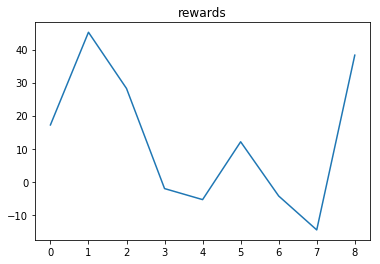

done


In [17]:
# training

for i in range(3):
    p1, a1 = capture(frames=1)
    
    # try out a different W
    trialW = W.copy() + np.random.randn(W.shape[0], W.shape[1]) * .5
    move_routine(trialW)
    
    p2, a2 = capture(frames=1)
    
    r = reward(p1, a1, p2, a2)
    
    rs.append(r)
    Ws.append(trialW)
    
plt.title("rewards")
plt.plot(rs)
plt.show()

print("done")

In [33]:
print("Training based on {} collected: ".format(len(Ws)))

learning_rate = .1

rs_norm = np.array(rs)
rs_norm -= np.mean(rs_norm)
rs_norm /= np.std(rs_norm)

for i in range(len(Ws)):
    W += Ws[i] * rs_norm[i] * learning_rate

Training based on 9 collected: 


In [20]:
# save brain
np.save('brain_trained', W)

In [41]:
# test it out
for i in range(1):
    move_routine(W)

BrokenPipeError: [Errno 32] Broken pipe

In [50]:
# reset state if needed

state = stand.copy()
move(state)

In [ ]:
# release the capture

cap.release()
cv2.destroyAllWindows()